# Example: Analyze Data From a Waveguide Cavity Resonator

This notebook will:
- calculate the theoretical frequency-response of a WR-2.8 waveguide cavity resonator
- use the dispersion transform to calculate the distance-domain response
- use the distance-domain response to isolate different reflections

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.constants as sc
from scipy.signal import find_peaks

# Dispersion-Compensated Transforms
# https://github.com/garrettj403/DispersionTransform
import disptrans

# SciKit-RF
# https://scikit-rf.readthedocs.io/
import skrf as rf
from skrf.media import RectangularWaveguide
from skrf.frequency import Frequency

# SciencePlots (optional)
# https://github.com/garrettj403/SciencePlots
plt.style.use(['science', 'notebook'])

np.seterr(divide = 'ignore');

In [3]:
def db20(value):
    """Convert linear voltage-like value to dB."""
    return 20 * np.log10(np.abs(value))

In [4]:
# Frequency sweep
freq  = Frequency(260, 300, 801, 'ghz')
print("Frequency sweep: ", freq)
print("Frequency step:   {:.1f} MHz".format((freq.f[1] - freq.f[0]) / sc.mega))

Frequency sweep:  260.0-300.0 GHz, 801 pts
Frequency step:   50.0 MHz


# Calculate waveguide properties using Scikit-RF package

Waveguide dimensions:
a: 0.711 mm
b: 0.356 mm
d: 2.540 cm


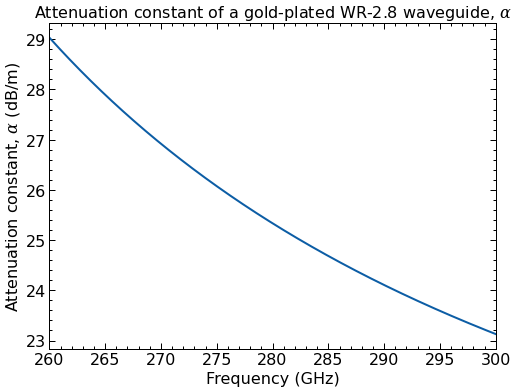

In [5]:
# Waveguide dimensions
a, b, d = 28 * sc.mil, 14 * sc.mil, 1 * sc.inch
print("Waveguide dimensions:")
print("a: {:.3f} mm".format(a / sc.milli))
print("b: {:.3f} mm".format(b / sc.milli))
print("d: {:.3f} cm".format(d / sc.centi))

# Create gold-plated WR-2.8 waveguide
wr2p8 = RectangularWaveguide(freq.copy(), a=a, b=b, rho=1/4.1e7)

# Unpack properties
beta = wr2p8.beta.copy()     # phase constant
vp = wr2p8.v_p.real.copy()   # phase velocity
vg = -wr2p8.v_g.imag.copy()  # group velocity

# Create 1 inch long waveguide
waveguide = wr2p8.line(d, unit='m')
waveguide.name = '{:.0f}" long WR-2.8 waveguide'.format(d / sc.inch)

# Waveguide attenuation
wg_att = -waveguide.s_db[:,1,0] / d

# Plot attenuation
plt.figure()
plt.plot(waveguide.f / 1e9, wg_att)
plt.autoscale(enable=True, axis='x', tight=True)
plt.title(r"Attenuation constant of a gold-plated WR-2.8 waveguide, $\alpha$")
plt.ylabel(r"Attenuation constant, $\alpha$ (dB/m)")
plt.xlabel("Frequency (GHz)");

# Calculate S-parameters of Iris

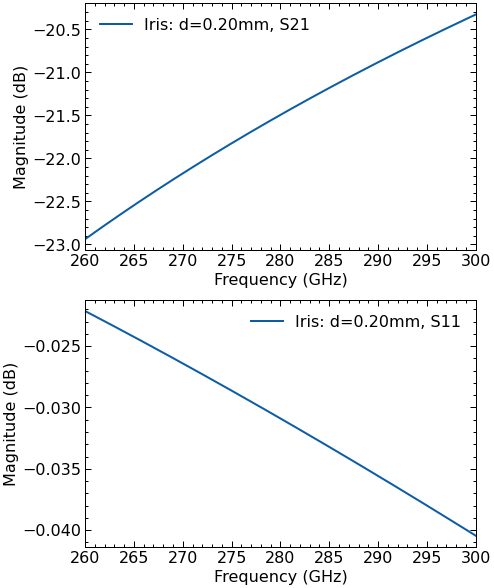

In [6]:
# Iris dimensions
diameter = 0.2 * sc.milli
radius = diameter / 2

# Calculate approximate iris shunt inductance (see Pozar)
alpha_m = 4 * radius ** 3 / 3
b_norm_iris = -wr2p8.a * wr2p8.b / (2 * wr2p8.beta * alpha_m)
b_iris = b_norm_iris / wr2p8.z0.real
l_iris = -1 / b_iris / (2 * sc.pi * wr2p8.frequency.f)

# Create iris component
iris = wr2p8.shunt_inductor(l_iris)
iris.name = "Iris: d={:.2f}mm".format(diameter/sc.milli)
iris_s11 = iris.s_db[:, 0, 0]
iris_s21 = iris.s_db[:, 1, 0]

# Plot insertion loss + return loss
fig, (ax1, ax2) = plt.subplots(2, figsize=(7, 10))
iris.plot_s_db(1, 0, ax=ax1)
iris.plot_s_db(0, 0, ax=ax2);

# Make resonator

# Cascade: Iris $\rightarrow$ Waveguide $\rightarrow$ Iris

In [7]:
# Cascade S-parameters
cavity = rf.connect(rf.connect(iris, 1, waveguide, 0), 1, iris, 1)
cavity.name = 'Waveguide resonator'

# Unpack
f = cavity.f.copy()
s21 = cavity.s[:, 1, 0].copy()
s11 = cavity.s[:, 0, 0].copy()
N = len(f)

# Add noise

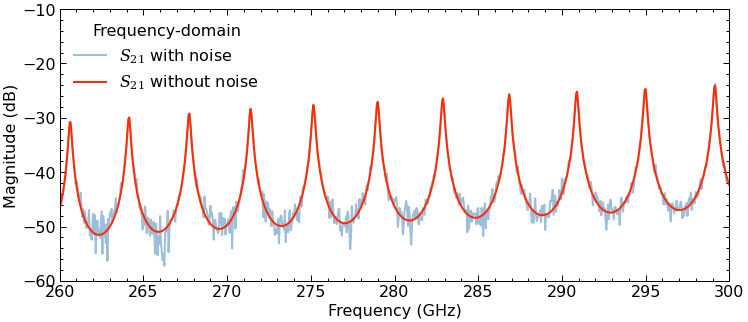

In [8]:
# AWGN with unity power
n1 = (np.random.randn(N) + 1j * np.random.randn(N)) / np.sqrt(2)

# Add noise
noise_floor_db = -60
noise_floor = 10 ** (noise_floor_db / 20)
s21n = s21 + n1 * noise_floor
s11n = s11 + n1 * noise_floor

# Plot magnitude
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(f/1e9, db20(s21n), '#0C5DA5', alpha=0.4, label=r"$S_{21}$ with noise")
ax.plot(f/1e9, db20(s21), '#FF2C00', ls='-', label=r"$S_{21}$ without noise")
ax.autoscale(enable=True, axis='x', tight=True)
ax.set(xlabel='Frequency (GHz)', ylabel='Magnitude (dB)')
ax.set_ylim([-60, -10])
ax.legend(title="Frequency-domain")
fig.savefig("results/cavity-freq-domain.jpg", dpi=300);

# Frequency-domain $\rightarrow$ spatial-domain

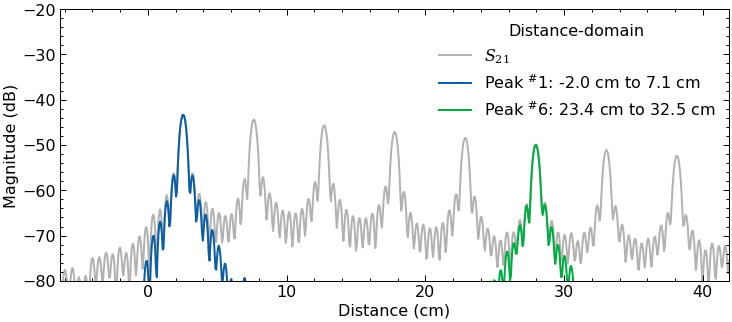

In [9]:
# Distance array
x = np.linspace(-2.5*sc.inch, 16.5*sc.inch, len(f))

# Frequency -> Distance-domain
s21x = disptrans.freq2distance(f, s21n, beta, x)
s11x = disptrans.freq2distance(f, s11n, beta, x)

# Window span
xspan = 1.8*sc.inch

# Window: 1st peak
x1a, x1b = 1*sc.inch-xspan, 1*sc.inch+xspan
idx1a, idx1b = np.abs(x - x1a).argmin(), np.abs(x - x1b).argmin()
window = np.r_[np.zeros(idx1a), 
#                tukey(idx1b-idx1a, 0.25),
               np.hamming(idx1b-idx1a),
               np.zeros(len(x)-idx1b)]
s21x_w1 = s21x * window
s21_xwindow1 = disptrans.distance2freq(x, s21x_w1, beta, f)

# Window: 5th peak
x2a, x2b = 11*sc.inch-xspan, 11*sc.inch+xspan
idx2a, idx2b = np.abs(x - x2a).argmin(), np.abs(x - x2b).argmin()
window = np.r_[np.zeros(idx2a), 
               np.hamming(idx2b-idx2a),
               np.zeros(len(x)-idx2b)]
s21x_w2 = s21x * window
s21_xwindow2 = disptrans.distance2freq(x, s21x_w2, beta, f)

# Plot spatial-domain response
plt.figure(figsize=(12, 5))
plt.plot(x * 100, db20(s21x), 'k', alpha=0.3, label=r"$S_{21}$")
plt.plot(x * 100, db20(s21x_w1), '#0C5DA5', ls='-', label='Peak $^\#$1: {:.1f} cm to {:.1f} cm'.format(x1a*100, x1b*100))
plt.plot(x * 100, db20(s21x_w2), '#00ad41', ls='-', label='Peak $^\#$6: {:.1f} cm to {:.1f} cm'.format(x2a*100, x2b*100))
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(title="Distance-domain")
plt.ylabel("Magnitude (dB)")
plt.xlabel("Distance (cm)")
plt.ylim([-80, -20])
plt.savefig("results/cavity-distance-domain.jpg", dpi=300);

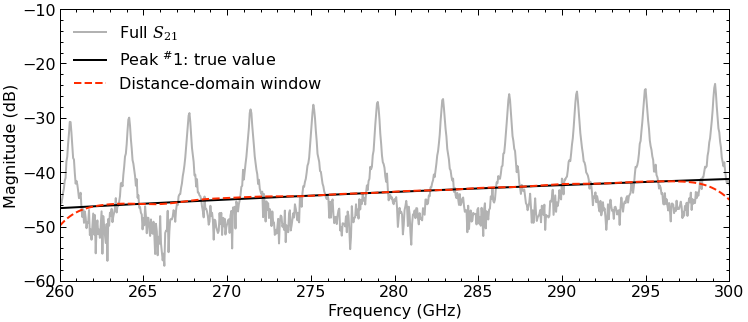

In [10]:
oneway = waveguide.s_db[:,1,0] + iris_s21 * 2

# Plot distance-gated data in frequency domain
fig, ax = plt.subplots(figsize=(12, 5))
plt.plot(f / 1e9, db20(s21n), 'k', alpha=0.3, label=r'Full $S_{21}$')
plt.plot(f / 1e9, oneway, 'k', ls='-', label="Peak $^\#$1: true value")
plt.plot(f / 1e9, db20(s21_xwindow1), '#FF2C00', ls='--', label='Distance-domain window')
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel("Frequency (GHz)")
plt.ylabel("Magnitude (dB)")
ax.set_ylim([-60, -10])
plt.legend()
fig.savefig("results/cavity-peak1.jpg", dpi=300);

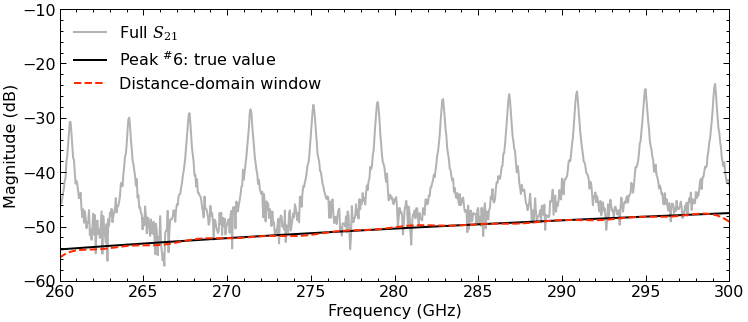

In [11]:
peak5 = waveguide.s_db[:,1,0] + iris_s21 * 2 + 5 * (iris_s11 * 2 + waveguide.s_db[:,1,0] * 2)

# Plot distance-gated data in frequency domain
fig, ax = plt.subplots(figsize=(12, 5))
plt.plot(f / 1e9, db20(s21n), 'k', alpha=0.3, label=r'Full $S_{21}$')
plt.plot(f / 1e9, peak5, 'k', ls='-', label="Peak $^\#$6: true value")
plt.plot(f / 1e9, db20(s21_xwindow2), '#FF2C00', ls='--', label='Distance-domain window')
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel("Frequency (GHz)")
plt.ylabel("Magnitude (dB)")
ax.set_ylim([-60, -10])
plt.legend()
fig.savefig("results/cavity-peak6.jpg", dpi=300);